In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

In [47]:
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

formatter = FuncFormatter(thousands)

In [2]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    

    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

In [3]:
# Load data

global_fits = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/04_globalfit_dms_degradation/global_refit_results.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)
fits

# get experimental info
main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,buffer_id
0,1,-6.816452,-8.121080,-11.629118,0.953716,0.110213,0.0,9.961597,7,25,4U_a8c,1
1,2,-5.267578,-8.121080,-6.841065,0.917437,0.150436,0.0,0.531036,7,25,4U_a8c,1
2,3,-4.680462,-8.121080,-5.801307,0.938039,0.129168,0.0,0.288928,7,25,4U_a8c,1
3,5,-7.617252,-8.121080,-7.020689,0.684740,0.339345,0.0,0.137336,7,25,4U_a8c,1
4,6,-6.082823,-8.121080,-6.875103,0.920598,0.147028,0.0,0.238243,7,25,4U_a8c,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,45,-3.500979,-3.623204,-6.523956,0.990812,0.043757,0.0,0.691059,118,70,hiv_c30u,4
6802,61,-4.128334,-3.623204,-8.138642,0.984694,0.056234,0.0,2.414572,118,70,hiv_c30u,4
6803,62,-4.218293,-3.623204,-8.518886,0.995414,0.030594,0.0,1.758088,118,70,hiv_c30u,4
6804,63,-6.942364,-3.623204,-6.424360,0.822663,0.207726,0.0,0.097666,118,70,hiv_c30u,4


In [4]:
# degradation rate from NMR

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['log_kdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['log_kdegT'] = np.log(df_kdeg['kdeg'] / (df_kdeg['temperature'] + 273.15))
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)
df_kdeg['disp_name'] = 'nmr'
df_kdeg = df_kdeg[['log_kdeg', 'log_kdegT', 'temperature', 'disp_name', 'inv_temp']]
# # linear fit to get curve
# model = lmfit.models.LinearModel()
# params = model.make_params()
# deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])

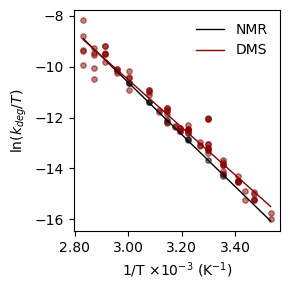

In [5]:
def linear_fit(df_kdeg):
    model = LinearModel()
    params = model.make_params()
    deg_result = model.fit(df_kdeg['log_kdegT'], params, x=df_kdeg['inv_temp'])
    return deg_result

# globally fitted kdeg vals - assessment of global fits
kdeg_curve = fits[fits['disp_name'].isin(['4U_a8c', '4U_wt'])]
# filter under temp 75
#kdeg_curve = kdeg_curve[kdeg_curve['temperature'] < 75]
kdeg_curve = kdeg_curve[['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()
kdeg_curve['inv_temp'] = 1/(273.15 + kdeg_curve['temperature'])
kdeg_curve = kdeg_curve[kdeg_curve['log_kdeg'] < -1]
kdeg_curve['log_kdegT'] = kdeg_curve['log_kdeg'] + np.log(kdeg_curve['inv_temp'])

kdeg_curve_nmr = df_kdeg[df_kdeg['disp_name'] == 'nmr']

fourU_result = linear_fit(kdeg_curve)
nmr_result = linear_fit(kdeg_curve_nmr)

# calc best fit
x_range = np.array([min(kdeg_curve['inv_temp'].min(), kdeg_curve_nmr['inv_temp'].min()), 
                    max(kdeg_curve['inv_temp'].max(), kdeg_curve_nmr['inv_temp'].max())])
fourU_bestfit = fourU_result.eval(x = x_range)
nmr_bestfit = nmr_result.eval(x = x_range)

concat = pd.concat([df_kdeg, kdeg_curve])
fig, ax = plt.subplots(figsize = (3, 3))
ax.scatter(x = kdeg_curve_nmr['inv_temp'], y = kdeg_curve_nmr['log_kdegT'], s=15, alpha = 0.5, color = 'black')
ax.plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = 'NMR')
# formatter = FuncFormatter(thousands)
# ax.xaxis.set_major_formatter(formatter)
# ax.set_ylabel(r'NMR $k_{deg}$ ($s^{-1}$)')
# ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
# plt.tight_layout()
# plt.savefig('nmr_kdeg', dpi=300)
# plt.show()

# fig, ax = plt.subplots(figsize = (3, 3))
ax.scatter(x = kdeg_curve['inv_temp'], y = kdeg_curve['log_kdegT'], s=15, alpha = 0.5, color = 'darkred')
ax.plot(x_range, fourU_bestfit, color = 'darkred', linewidth = 1, label = 'DMS')
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg}/T)$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.legend(frameon = False)
plt.tight_layout()
plt.savefig('eyring_kdeg.pdf')
plt.show()

In [6]:
import pandas as pd

# Example structure
df1 = kdeg_curve[['log_kdegT', 'inv_temp']].copy()
df2 = kdeg_curve_nmr[['log_kdegT', 'inv_temp']].copy()

df1['Group'] = 'dms'
df2['Group'] = 'nmr'

df_combined = pd.concat([df1, df2])

import statsmodels.formula.api as smf

# Group is binary (0 or 1)
# 'x:Group' is the interaction term (slope difference)
model = smf.ols('log_kdegT ~ inv_temp * Group', data=df_combined).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_kdegT   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     777.5
Date:                Fri, 23 May 2025   Prob (F-statistic):           1.05e-65
Time:                        16:57:33   Log-Likelihood:                -38.773
No. Observations:                  97   AIC:                             85.55
Df Residuals:                      93   BIC:                             95.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                17.60

In [8]:
import scipy.constants as sc

def calc_dH_dS(m, m_err, b, b_err):
    dH = - m * sc.R/sc.calorie
    dH_err = m_err * sc.R/sc.calorie
    dS = (b - np.log(sc.Boltzmann / sc.Planck)) * sc.R/sc.calorie
    dS_err = b_err * sc.R/sc.calorie
    return [dH, dH_err, dS, dS_err]

<BarContainer object of 2 artists>

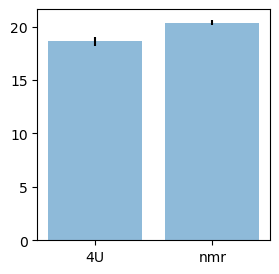

In [9]:
dH_dS_vals = []
for fit in [fourU_result, nmr_result]:
    dH_dS_vals.append(calc_dH_dS(fit.params['slope'].value, fit.params['slope'].stderr, fit.params['intercept'].value, fit.params['intercept'].stderr))

dH_dS_vals = pd.DataFrame(dH_dS_vals, columns = ['dH', 'dH_err', 'dS', 'dS_err'])

dH_dS_vals['dH'] = dH_dS_vals['dH'] / 1000 # convert to kcal/mol
dH_dS_vals['dH_err'] = dH_dS_vals['dH_err'] / 1000 # convert to kcal/mol

dH_dS_vals['var'] = ['4U', 'nmr']

# barplot
fig, ax = plt.subplots(figsize = (3, 3))
ax.bar(x = dH_dS_vals['var'], height = dH_dS_vals['dH'], yerr = dH_dS_vals['dH_err'], alpha = 0.5)
#ax.bar(x = dH_dS_vals['var'], height = dH_dS_vals['dS'], yerr = dH_dS_vals['dS_err'], color = 'black', alpha = 0.5)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


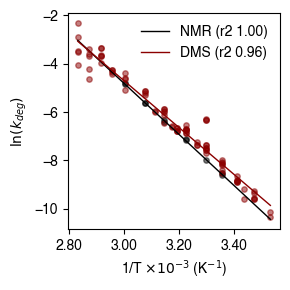

In [62]:
def linear_fit(df_kdeg):
    model = LinearModel()
    params = model.make_params()
    deg_result = model.fit(df_kdeg['log_kdeg'], params, x=df_kdeg['inv_temp'])
    return deg_result

# globally fitted kdeg vals - assessment of global fits
kdeg_curve = fits[fits['disp_name'].isin(['4U_a8c', '4U_wt'])]
# filter under temp 75
#kdeg_curve = kdeg_curve[kdeg_curve['temperature'] < 75]
kdeg_curve = kdeg_curve[['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()
kdeg_curve['inv_temp'] = 1/(273.15 + kdeg_curve['temperature'])
kdeg_curve = kdeg_curve[kdeg_curve['log_kdeg'] < -1]

kdeg_curve_nmr = df_kdeg[df_kdeg['disp_name'] == 'nmr']

fourU_result = linear_fit(kdeg_curve)
nmr_result = linear_fit(kdeg_curve_nmr)


# annotate r2
r2_dms = fourU_result.rsquared
r2_nmr = nmr_result.rsquared


# calc best fit
x_range = np.array([min(kdeg_curve['inv_temp'].min(), kdeg_curve_nmr['inv_temp'].min()), 
                    max(kdeg_curve['inv_temp'].max(), kdeg_curve_nmr['inv_temp'].max())])
fourU_bestfit = fourU_result.eval(x = x_range)
nmr_bestfit = nmr_result.eval(x = x_range)

concat = pd.concat([df_kdeg, kdeg_curve])
fig, ax = plt.subplots(figsize = (3, 3))
ax.scatter(x = kdeg_curve_nmr['inv_temp'], y = kdeg_curve_nmr['log_kdeg'], s=15, alpha = 0.5, color = 'black')
ax.plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = f'NMR (r2 {r2_nmr:.2f})')
# formatter = FuncFormatter(thousands)
# ax.xaxis.set_major_formatter(formatter)
# ax.set_ylabel(r'NMR $k_{deg}$ ($s^{-1}$)')
# ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
# plt.tight_layout()
# plt.savefig('nmr_kdeg', dpi=300)
# plt.show()

# fig, ax = plt.subplots(figsize = (3, 3))


ax.scatter(x = kdeg_curve['inv_temp'], y = kdeg_curve['log_kdeg'], s=15, alpha = 0.5, color = 'darkred')
ax.plot(x_range, fourU_bestfit, color = 'darkred', linewidth = 1, label = f'DMS (r2 {r2_dms:.2f})')
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.legend(frameon = False)

plt.tight_layout()
plt.savefig('arrhenius_kdeg.pdf')
plt.show()

In [21]:
kdeg_data_nmr = kdeg_curve_nmr[['log_kdeg', 'inv_temp', 'disp_name']]
kdeg_data_dms = kdeg_curve[['log_kdeg', 'inv_temp', 'disp_name']]
kdeg_data_all = pd.concat([kdeg_data_nmr, kdeg_data_dms])
print(kdeg_data_all.head())
#kdeg_curve

   log_kdeg  inv_temp disp_name
0 -8.515835  0.003354       nmr
1 -8.618560  0.003354       nmr
2 -7.972393  0.003299       nmr
3 -7.121162  0.003224       nmr
4 -7.166917  0.003224       nmr


In [22]:
import statsmodels.formula.api as smf

In [26]:

# Fit ANCOVA model: ln(k) ~ invT * method
model = smf.ols('log_kdeg ~ inv_temp * C(disp_name, Treatment(reference="nmr"))', data = kdeg_data_all).fit() # nmr be reference
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_kdeg   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     551.7
Date:                Sat, 24 May 2025   Prob (F-statistic):           2.01e-66
Time:                        10:00:34   Log-Likelihood:                -32.990
No. Observations:                  97   AIC:                             77.98
Df Residuals:                      91   BIC:                             93.43
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
from scipy.constants import R, calorie

# Constants
R_val = R / (1000 * calorie)  # kcal/mol/K

# Base values from NMR (reference group)
slope_nmr = model.params['inv_temp']
slope_err_nmr = model.bse['inv_temp']
intercept_nmr = model.params['Intercept']
intercept_err_nmr = model.bse['Intercept']

# Collect values for each group
groups = ['nmr', '4U_wt', '4U_a8c']
results = []

for group in groups:
    if group == 'nmr':
        slope = slope_nmr
        slope_err = slope_err_nmr
        intercept = intercept_nmr
        intercept_err = intercept_err_nmr
    else:
        slope = slope_nmr + model.params[f'inv_temp:C(disp_name, Treatment(reference="nmr"))[T.{group}]']
        slope_err = np.sqrt(
            slope_err_nmr**2 +
            model.bse[f'inv_temp:C(disp_name, Treatment(reference="nmr"))[T.{group}]']**2
        )

        intercept = intercept_nmr + model.params[f'C(disp_name, Treatment(reference="nmr"))[T.{group}]']
        intercept_err = np.sqrt(
            intercept_err_nmr**2 +
            model.bse[f'C(disp_name, Treatment(reference="nmr"))[T.{group}]']**2
        )

    Ea = -slope * R_val
    Ea_err = slope_err * R_val

    results.append({
        'group': group,
        'Ea_kcal_per_mol': Ea,
        'Ea_error': Ea_err,
        'lnA': intercept,
        'lnA_error': intercept_err
    })

# Create DataFrame
df_arrhenius = pd.DataFrame(results)
df_arrhenius = df_arrhenius.set_index('group')

df_arrhenius

,Ea_kcal_per_mol,Ea_error,lnA,lnA_error
group,,,,
nmr,20.999840,1.711583,26.885756,2.734402
4U_wt,18.762551,2.469306,23.452496,3.946536
4U_a8c,19.694234,2.495644,25.178269,3.985959


In [46]:
from scipy.stats import t

# Function to compute t-stat and p-value
def t_test_pairwise(val1, se1, val2, se2):
    t_stat = (val1 - val2) / np.sqrt(se1**2 + se2**2)
    df = np.inf  # Assume normal approximation
    p_val = 2 * t.sf(np.abs(t_stat), df)
    return t_stat, p_val

# Compare nmr vs each of the other groups
reference = 'nmr'
comparisons = ['4U_wt', '4U_a8c']

for comp in comparisons:
    print(f"\nComparison: {reference} vs {comp}")
    
    # Ea comparison
    t_ea, p_ea = t_test_pairwise(
        df_arrhenius.loc[reference, 'Ea_kcal_per_mol'],
        df_arrhenius.loc[reference, 'Ea_error'],
        df_arrhenius.loc[comp, 'Ea_kcal_per_mol'],
        df_arrhenius.loc[comp, 'Ea_error']
    )
    print(f"  Ea: t = {t_ea:.3f}, p = {p_ea:.4f}")
    
    # lnA comparison
    t_lna, p_lna = t_test_pairwise(
        df_arrhenius.loc[reference, 'lnA'],
        df_arrhenius.loc[reference, 'lnA_error'],
        df_arrhenius.loc[comp, 'lnA'],
        df_arrhenius.loc[comp, 'lnA_error']
    )
    print(f"  lnA: t = {t_lna:.3f}, p = {p_lna:.4f}")


Comparison: nmr vs 4U_wt
  Ea: t = 0.745, p = 0.4565
  lnA: t = 0.715, p = 0.4746

Comparison: nmr vs 4U_a8c
  Ea: t = 0.431, p = 0.6662
  lnA: t = 0.353, p = 0.7239


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


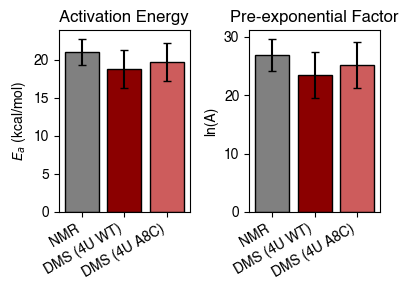

In [55]:
import matplotlib.pyplot as plt

# Map groups to display names and colors
group_labels = {
    'nmr': 'NMR',
    '4U_wt': 'DMS (4U WT)',
    '4U_a8c': 'DMS (4U A8C)'
}
colors = {
    'nmr': 'gray',
    '4U_wt': '#8B0000',   # dark red
    '4U_a8c': '#CD5C5C'   # indian red / lighter red
}

# Get bar positions
groups = ['nmr', '4U_wt', '4U_a8c']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'Ea_kcal_per_mol'],
    yerr=df_arrhenius.loc[groups, 'Ea_error'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[0].set_title('Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_error'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[1].set_title('Pre-exponential Factor')
axs[1].set_ylabel('ln(A)')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('arrhenius_barplot.pdf')
plt.show()

In [14]:
import numpy as np
from scipy.stats import t

# Extract slope and stderr
m1, se1 = dH_dS_vals.iloc[0]['m'], dH_dS_vals.iloc[0]['m_err']
m2, se2 = dH_dS_vals.iloc[1]['m'], dH_dS_vals.iloc[1]['m_err']

# Compute t-statistic
t_stat = (m1 - m2) / np.sqrt(se1**2 + se2**2)

# Degrees of freedom (conservative)
df = 2  # or min(n1-2, n2-2) if known

# Two-sided p-value
p_val = 2 * t.sf(np.abs(t_stat), df)

print(f"t = {t_stat:.4f}, p = {p_val:.4f}")

t = 3.6872, p = 0.0663


In [15]:
b1, eb1 = dH_dS_vals.iloc[0]['b'], dH_dS_vals.iloc[0]['b_err']
b2, eb2 = dH_dS_vals.iloc[1]['b'], dH_dS_vals.iloc[1]['b_err']
t_b = (b1 - b2) / np.sqrt(eb1**2 + eb2**2)
p_b = 2 * t.sf(np.abs(t_b), df)

print(f"Intercept comparison: t = {t_b:.4f}, p = {p_b:.4f}")

Intercept comparison: t = -3.3308, p = 0.0795
